## Draft of code for CDF inversion method

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import yaml
from datetime import datetime
import sklearn
from tqdm.auto import tqdm

from src.lib.experimentation import load_amex_numpy_data, undo_min_max_corrupt_func
import pandas as pd
import numpy as np 
import seaborn as sns
from src.lib.plotting import get_figsize, save_plot, update_plot_params

with open(os.path.join("..", "config.yaml")) as f:
    main_cfg = yaml.load(f, Loader=yaml.FullLoader)
    
with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-alpha.yaml")) as f:
    amex_cfg = yaml.load(f, Loader=yaml.FullLoader)

with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-beta.yaml")) as f:
    lob_cfg = yaml.load(f, Loader=yaml.FullLoader)
    


In [46]:
X_train, y_train = load_amex_numpy_data(
    os.path.join(main_cfg['dataset_directory'], "derived", "processed-splits"),
    amex_cfg['amex_dataset']['fill'],
    lambda X, y: undo_min_max_corrupt_func(X, y, 42),
    11,
)
print(X_train.shape)

(458913, 13, 188)


In [47]:
from scipy.stats import ecdf, norm
import copy

class InvertCDFTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_series_length : int = 13, epsilon = 1e-6):
        self.ecdf_objects = None
        self.T = time_series_length
        self.d = None
        self.eps = epsilon

    def fit(self, X, y = None):
        assert X.shape[1] == self.T
        self.d = X.shape[2]
        
        X = X.reshape((-1, self.d))
        self.ecdf_objects = []
        # go through all the predictor variables, and estimate their CDFs
        for j in tqdm(range(self.d), desc="Fitting CDF inverter"):
            self.ecdf_objects.append(
                ecdf(X[:, j])
            )
        return self

    def transform(self, X):
        assert X.shape[1] == self.T
        assert (self.ecdf_objects is not None) and (X.shape[2] == self.d)
        
        X = copy.deepcopy(X)
        
        X = X.reshape((-1, self.d))
        
        # apply the inverse CDF transformation
        for j in tqdm(range(self.d), desc="Transforming data with CDF inverter"):
            X[:, j] = norm.ppf(self.ecdf_objects[j].cdf.evaluate(X[:, j]) * (1 - self.eps) + self.eps / 2)
        
        X = X.reshape((-1, self.T, self.d))
        return X
    
    def __repr__(self, N_CHAR_MAX=None):
        return "InvertCDFTimeSeries(...)"
    
cdf_inverter = InvertCDFTimeSeries()
cdf_inverter.fit(X_train[:, :, 11:20])
X_transformed = cdf_inverter.transform(X_train[:, :, 11:20])

Fitting CDF inverter:   0%|          | 0/9 [00:00<?, ?it/s]

Transforming data with CDF inverter:   0%|          | 0/9 [00:00<?, ?it/s]

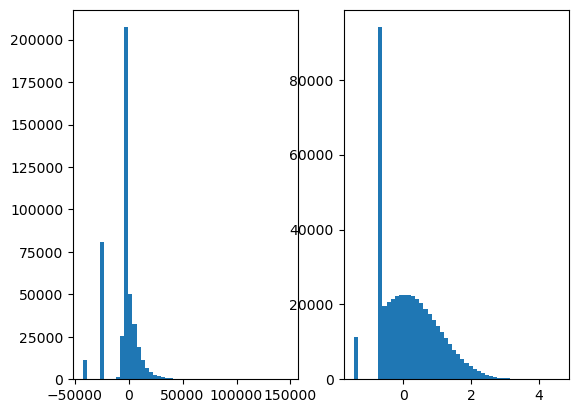

In [48]:
fig, axs = plt.subplots(ncols=2)
j = 5
axs[0].hist(X_train[:, 10, 11+j], bins=50)
axs[1].hist(X_transformed[:, 10, j], bins=50)
plt.show()

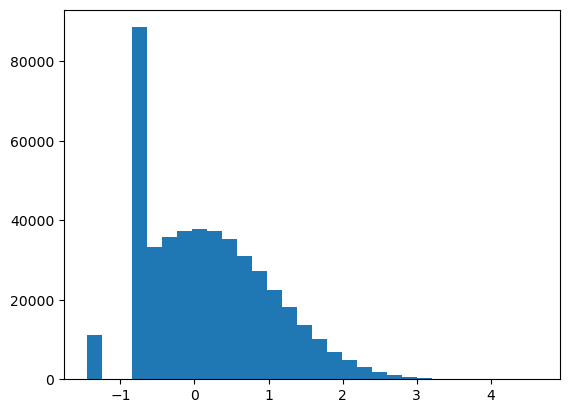

In [45]:
cdf_obj = ecdf(X_train[:, :, 11+j].reshape((-1)))
plt.hist(norm.ppf(cdf_obj.cdf.evaluate(X_train[:, 10, 11+j])), bins=30)
plt.show()